# Proyecto final - SA y GA aplicado a JSP

MA4402 - Simulación Estocástica: Teoría y Laboratorio

Profesor: Joaquín Fontobona T.

Auxiliares: Catalina Lizana, Álvaro Márquez, Matías Ortiz

**Integrantes:**
- Nicolás Fuenzalida
- Sebastián Lemus

El problema de programación de trabajos, o JSP, es un problema muy estudiado en optimización combinatorial. Se abordará JSP con simulated annealing (SA) y el algoritmo genético (GA). 

En JSP, se dan $n$ tareas, cada una compuesta por $m$ operaciones, y hay $m$ máquinas. Cada máquina debe realizar una única vez cada tarea y no se puede realizar la misma tarea en distintas máquinas al mismo tiempo.

El orden en el que las operaciones de una tarea debe realizarse está fijo para un horario.

El objetivo es encontrar un orden $\sigma$ de las operaciones en cada tarea de modo tal que el tiempo de finalización se minimice

Primero que nada, se importan las librerías.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import time

In [2]:
# Para evitar algunos cuadros de diálogo
import warnings
warnings.filterwarnings("ignore")

Se presenta la paleta de colores utilizada.

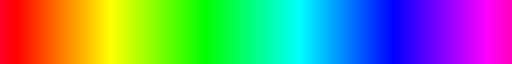

In [3]:
plt.colormaps['gist_rainbow']

Vamos a definir una función para poder visualizar los horarios, dando de input la lista de instancias y las máquinas, es llamado Gantt Chart.

In [4]:
# Definimos la función para plotear
def plot_gantt_chart(lista_instancias, maquinas):
    fig, ax = plt.subplots()
    # Obtener un mapa de colores igual a la cantidad de tareas
    # para asignar un color con una tarea.
    colors = plt.cm.get_cmap('gist_rainbow', len(lista_instancias))
    # Se guardan los tiempos finales
    end_times = []
    # Retorna el índice y el valor recorriendo la lista_instancias
    for i, task in enumerate(lista_instancias):
        # Color para una tarea
        task_color = colors(i) 
        for j, operation in enumerate(task):
            # Tiempos de inicio, duración, finalización y máquina
            start_time = operation[0]
            processing_time = operation[1]
            end_time = start_time + processing_time
            end_times += [end_time]
            machine = operation[2]
            ax.barh(machine, width=processing_time, left=start_time,
                    color=task_color, edgecolor='black', label=f'Task {i+1}')
    ax.set_yticks(np.arange(0, maquinas, 1))
    ax.set_xlim(0,max(end_times))
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Máquinas')
    ax.invert_yaxis()
    plt.show()

In [5]:
# Ahora, se define el costo para un horario. El costo se tomará
# como el tiempo de finalización de la última operación.

# Vamos a replicar el proceso anterior, enfocándonos solamente
# en la duración de las tareas.
def costos(orden,tiempos,filas,columnas):    
    orden_operaciones = orden.copy()
    lista_de_listas = [[[0,0,0]] * columnas for fila in range(filas)]
    lista_de_operaciones = [[] for ops in range(columnas)]
    contador = 0
    for i in range(columnas):
        for j in range(filas):
            lista_de_operaciones[i]+=[contador]
            contador += 1
    lista_de_tareas = [[] for tareas in range(filas)]
    contador2 = 0
    for k in range(columnas):
        for l in range(filas):
            lista_de_tareas[l] += [contador2]
            contador2 += 1
    lista_de_tiempos = tiempos.copy()
    contador2 = 0
    for m in range(columnas):
        for n in range(filas):
            lista_de_tareas[n] += [contador2]
            contador2 += 1
    indicatriz_inicio_tarea = [0 for inicios in range(filas)]
    tiempos_finales_por_maquina = [0 for tiempos_finales in range(columnas)]    
    tiempos_finales_por_tarea = [0 for tiempos_finales in range(filas)]

    # Iteramos sobre el orden de operaciones
    for orden in orden_operaciones:
        # Iteramos sobre las listas de tareas y buscamos en qué tarea está sacando su índice
        for tarea_actual in lista_de_tareas:
            # Si la operación actual está en una lista
            if orden in tarea_actual:
                # Buscamos el índice de la tarea entre 1 a n
                indice_tarea_actual = lista_de_tareas.index(tarea_actual)
                
        for operacion_actual in lista_de_operaciones:
            # Si la operación actual está en una lista
            if orden in operacion_actual:
                # Buscamos el índice de la tarea entre 1 a m
                indice_maquina_actual = lista_de_operaciones.index(operacion_actual)
        # Hay que ver las indicatrices, es decir, ver si se ejecutó ya una tarea
        # o si se ocupó ya la máquina en la que está la operación actual.

        # Si la tarea aún no se ha ejecutado
        if indicatriz_inicio_tarea[indice_tarea_actual] == 0:
            # Marcamos que la tarea se ejecutó
            indicatriz_inicio_tarea[indice_tarea_actual] = 1
            # Una vez que marcamos que la tarea y máquina asociada al orden actual están en uso,
            # tenemos que fijar los tiempos de inicio, duración y máquina para el orden actual.
            # Para eso, tenemos que llamar a la la lista de instancias, en la tarea asociada:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            # Tiempo de inicio
            instancia_actual[0] = tiempos_finales_por_maquina[indice_maquina_actual] 
            # Duración tarea y actualizar tiempo final máquina
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] += lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            # Máquina asociada
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
        # Si la tarea ya se ha ejecutado
        elif indicatriz_inicio_tarea[indice_tarea_actual] == 1:
            # Una vez que marcamos que la tarea y máquina asociada al orden actual están en uso,
            # tenemos que fijar los tiempos de inicio, duración y máquina para el orden actual.
            # Para eso, tenemos que llamar a la la lista de instancias, en la tarea asociada:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            # Tiempo de inicio
            instancia_actual[0] = max(tiempos_finales_por_tarea[indice_tarea_actual], tiempos_finales_por_maquina[indice_maquina_actual])
            # Duración tarea y actualizar tiempo final máquina
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] = instancia_actual[0] + lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            # Máquina asociada
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
    max1 = max(tiempos_finales_por_tarea)
    max2 = max(tiempos_finales_por_maquina)
    tiempo_maximo2 = max(max1,max2)
    return tiempo_maximo2

Ahora la idea es generar estas instancias al azar para darle una condición inicial al problema del cual empiece la iteración del algoritmo. Es decir, ahora pasamos lo que hicimos anteriormente a una función que repita este proceso.

In [6]:
# Ahora crearemos una función que repita este procedimiento
# para solamente tener que llamar a la función
def generar_instancias(maquinas,tareas):
    filas = tareas
    columnas = maquinas
    orden_operaciones = random.sample(range(0, filas*columnas), filas*columnas)
    lista_de_listas = [[[0,0,0]] * columnas for fila in range(filas)]
    # Generar la lista de n valores enteros al azar
    lista_de_tiempos = [random.randint(1, 100) for tiempos in range(filas*columnas)]
    lista_de_operaciones = [[] for ops in range(columnas)]
    contador = 0
    for i in range(columnas):
        for j in range(filas):
            lista_de_operaciones[i]+=[contador]
            contador += 1
    lista_de_tareas = [[] for tareas in range(filas)]
    contador2 = 0
    for k in range(columnas):
        for l in range(filas):
            lista_de_tareas[l] += [contador2]
            contador2 += 1
    
    indicatriz_inicio_tarea = [0 for inicios in range(filas)]
    tiempos_finales_por_maquina = [0 for tiempos_finales in range(columnas)]
    tiempos_finales_por_tarea = [0 for tiempos_finales in range(filas)]
    # Iteramos sobre el orden de operaciones
    for orden in orden_operaciones:
        # Iteramos sobre las listas de tareas y buscamos en qué tarea está sacando su índice
        for tarea_actual in lista_de_tareas:
            # Si la operación actual está en una lista
            if orden in tarea_actual:
                # Buscamos el índice de la tarea entre 1 a n
                indice_tarea_actual = lista_de_tareas.index(tarea_actual)   
        for operacion_actual in lista_de_operaciones:
            # Si la operación actual está en una lista
            if orden in operacion_actual:
                # Buscamos el índice de la tarea entre 1 a m
                indice_maquina_actual = lista_de_operaciones.index(operacion_actual)
        # Hay que ver las indicatrices, es decir, ver si se ejecutó ya una tarea
        # o si se ocupó ya la máquina en la que está la operación actual.

        # Si la tarea aún no se ha ejecutado
        if indicatriz_inicio_tarea[indice_tarea_actual] == 0:
            # Marcamos que la tarea se ejecutó
            indicatriz_inicio_tarea[indice_tarea_actual] = 1
            # Una vez que marcamos que la tarea y máquina asociada al orden actual están en uso,
            # tenemos que fijar los tiempos de inicio, duración y máquina para el orden actual.
            # Para eso, tenemos que llamar a la la lista de instancias, en la tarea asociada:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            # Tiempo de inicio
            instancia_actual[0] = tiempos_finales_por_maquina[indice_maquina_actual] 
            # Duración tarea y actualizar tiempo final máquina
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] += lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            # Máquina asociada
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
        
        # Si la tarea ya se ha ejecutado
        elif indicatriz_inicio_tarea[indice_tarea_actual] == 1:
            # Una vez que marcamos que la tarea y máquina asociada al orden actual están en uso,
            # tenemos que fijar los tiempos de inicio, duración y máquina para el orden actual.
            # Para eso, tenemos que llamar a la la lista de instancias, en la tarea asociada:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            # Tiempo de inicio
            instancia_actual[0] = max(tiempos_finales_por_tarea[indice_tarea_actual], tiempos_finales_por_maquina[indice_maquina_actual])
            # Duración tarea y actualizar tiempo final máquina
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] = instancia_actual[0] + lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            # Máquina asociada
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
    tiempo_maximo = costos(orden_operaciones,lista_de_tiempos,tareas,maquinas)
    return lista_de_listas, tiempo_maximo, orden_operaciones, lista_de_tiempos

In [7]:
# Necesitamos también una función que dado un orden de operaciones,la cantidad
# de máquinas, tareas y una lista de tiempos, retorne la lista de instancias.

# Esta es similar a generar_instancias, pero aquí está fijo el orden
# y la lista de tiempos de los órdenes.
def lista_instancias(orden,tiempos,maquinas,tareas):
    filas = tareas
    columnas = maquinas
    orden_operaciones = orden
    lista_de_listas = [[[0,0,0]] * columnas for fila in range(filas)]
    lista_de_tiempos = tiempos
    lista_de_operaciones = [[] for ops in range(columnas)]
    contador = 0
    for i in range(columnas):
        for j in range(filas):
            lista_de_operaciones[i]+=[contador]
            contador += 1
    lista_de_tareas = [[] for tareas in range(filas)]
    contador2 = 0
    for k in range(columnas):
        for l in range(filas):
            lista_de_tareas[l] += [contador2]
            contador2 += 1
    indicatriz_inicio_tarea = [0 for inicios in range(filas)]
    tiempos_finales_por_maquina = [0 for tiempos_finales in range(columnas)]
    tiempos_finales_por_tarea = [0 for tiempos_finales in range(filas)]
    # Parte 2
    for orden in orden_operaciones:
        for tarea_actual in lista_de_tareas:
            if orden in tarea_actual:
                indice_tarea_actual = lista_de_tareas.index(tarea_actual)
        for operacion_actual in lista_de_operaciones:
            if orden in operacion_actual:
                indice_maquina_actual = lista_de_operaciones.index(operacion_actual)
        if indicatriz_inicio_tarea[indice_tarea_actual] == 0:
            indicatriz_inicio_tarea[indice_tarea_actual] = 1
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            instancia_actual[0] = tiempos_finales_por_maquina[indice_maquina_actual] 
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] += lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
        elif indicatriz_inicio_tarea[indice_tarea_actual] == 1:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            instancia_actual[0] = max(tiempos_finales_por_tarea[indice_tarea_actual], tiempos_finales_por_maquina[indice_maquina_actual])
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] = instancia_actual[0] + lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
    return lista_de_listas

In [8]:
# Ahora vamos a definir las vecindades de un horario, para ello vamos a
# alternar el orden del horario, intercambiando dos operaciones entre sí,
# lo cual define un vecino. Dos horarios con un orden son vecinas si se
# obtiene permutando exactamente 2 operaciones.
def neighborhood(orden_operaciones_original,lista_de_tiempos_original,filas,columnas):
    # Creamos una copia del orden y tiempo
    copia_orden = orden_operaciones_original.copy()
    copia_tiempo = lista_de_tiempos_original.copy()
    # Elegimos dos operaciones al azar
    a = np.random.randint(1,len(copia_orden))
    b = np.random.randint(1,len(copia_orden))
    # Nos aseguramos que elegimos distintos índices
    while a==b:
        b = np.random.randint(1,len(copia_orden))
    # Intercambiamos las operaciones
    orden_a, tiempo_a = copia_orden[a], copia_tiempo[a]
    copia_orden[a], copia_tiempo[a] = copia_orden[b], copia_tiempo[b]
    copia_orden[b], copia_tiempo[b] = orden_a, tiempo_a
    
    orden_operaciones = copia_orden.copy()
    lista_de_listas = [[[0,0,0]] * columnas for fila in range(filas)]
    lista_de_operaciones = [[] for ops in range(columnas)]
    contador = 0
    for i in range(columnas):
        for j in range(filas):
            lista_de_operaciones[i]+=[contador]
            contador += 1
    lista_de_tareas = [[] for tareas in range(filas)]
    contador2 = 0
    for k in range(columnas):
        for l in range(filas):
            lista_de_tareas[l] += [contador2]
            contador2 += 1
    lista_de_tiempos = copia_tiempo.copy()
    contador2 = 0
    for m in range(columnas):
        for n in range(filas):
            lista_de_tareas[n] += [contador2]
            contador2 += 1
    indicatriz_inicio_tarea = [0 for inicios in range(filas)]
    tiempos_finales_por_maquina = [0 for tiempos_finales in range(columnas)]    
    tiempos_finales_por_tarea = [0 for tiempos_finales in range(filas)]

    # Iteramos sobre el orden de operaciones
    for orden in orden_operaciones:
        # Iteramos sobre las listas de tareas y buscamos en qué tarea está sacando su índice
        for tarea_actual in lista_de_tareas:
            # Si la operación actual está en una lista
            if orden in tarea_actual:
                # Buscamos el índice de la tarea entre 1 a n
                indice_tarea_actual = lista_de_tareas.index(tarea_actual)
                
        for operacion_actual in lista_de_operaciones:
            # Si la operación actual está en una lista
            if orden in operacion_actual:
                # Buscamos el índice de la tarea entre 1 a m
                indice_maquina_actual = lista_de_operaciones.index(operacion_actual)
        # Hay que ver las indicatrices, es decir, ver si se ejecutó ya una tarea
        # o si se ocupó ya la máquina en la que está la operación actual.

        # Si la tarea aún no se ha ejecutado
        if indicatriz_inicio_tarea[indice_tarea_actual] == 0:
            # Marcamos que la tarea se ejecutó
            indicatriz_inicio_tarea[indice_tarea_actual] = 1
            # Una vez que marcamos que la tarea y máquina asociada al orden actual están en uso,
            # tenemos que fijar los tiempos de inicio, duración y máquina para el orden actual.
            # Para eso, tenemos que llamar a la la lista de instancias, en la tarea asociada:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            # Tiempo de inicio
            instancia_actual[0] = tiempos_finales_por_maquina[indice_maquina_actual] 
            # Duración tarea y actualizar tiempo final máquina
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] += lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            # Máquina asociada
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
        # Si la tarea ya se ha ejecutado
        elif indicatriz_inicio_tarea[indice_tarea_actual] == 1:
            # Una vez que marcamos que la tarea y máquina asociada al orden actual están en uso,
            # tenemos que fijar los tiempos de inicio, duración y máquina para el orden actual.
            # Para eso, tenemos que llamar a la la lista de instancias, en la tarea asociada:
            instancia_actual = lista_de_listas[indice_tarea_actual][indice_maquina_actual].copy()
            # Tiempo de inicio
            instancia_actual[0] = max(tiempos_finales_por_tarea[indice_tarea_actual], tiempos_finales_por_maquina[indice_maquina_actual])
            # Duración tarea y actualizar tiempo final máquina
            instancia_actual[1] = lista_de_tiempos[orden]
            tiempos_finales_por_maquina[indice_maquina_actual] = instancia_actual[0] + lista_de_tiempos[orden]
            tiempos_finales_por_tarea[indice_tarea_actual] = instancia_actual[0] + instancia_actual[1]
            # Máquina asociada
            instancia_actual[2] = indice_maquina_actual
            lista_de_listas[indice_tarea_actual][indice_maquina_actual] = instancia_actual
    tiempo_maximo = costos(orden_operaciones,lista_de_tiempos,filas,columnas)
    return lista_de_listas, orden_operaciones,lista_de_tiempos, tiempo_maximo

In [9]:
# Implementación del método simulated annealing
# Lo ajustamos para el JSP
def sim_ann(N,funcion,orden_i,tiempos,filas,columnas):
    # Generamos la lista para guardar los estados de
    # la CM, los tiempos y los pesos
    largo = len(orden_i)
    MC = np.zeros((N+1,largo),dtype=int)
    MC_tiempos = np.zeros((N+1,largo),dtype=int)
    pos = orden_i.copy()
    pos_tiempo = tiempos.copy()
    Pesos = np.zeros(N+1,dtype=int)
    Pesos[0] = costos(orden_i,tiempos,filas,columnas)
    for j in range(largo):
        MC[0,j] = orden_i[j]
        MC_tiempos[0,j] = tiempos[j]
    tamaño = len(orden_i)
    # Generamos las N v.a. uniformes
    u = np.random.uniform(0, 1, N)
    # Definimos la constante C
    # Esta va a ser el costo del orden inicial.
    C = costos(orden_i,tiempos,filas,columnas)
    for n in range(N):
        pos_cost = costos(pos,pos_tiempo,filas,columnas)
        a,new_sigma,new_time,b = neighborhood(pos,pos_tiempo,filas,columnas)
        # Se calcula el nuevo costo
        new_cost = costos(new_sigma,new_time,filas,columnas)
        # Se calcula beta_n, dependiendo de la función beta escogida
        beta = funcion(n,C)
        # Se calcula el exponente y demás valores
        exponente = beta*(new_cost-pos_cost)
        cte1= np.exp(-exponente)
        cte = min(1.0, cte1)
        # Condición de uniforme menor que la constante
        if u[n] <= cte:
            pos = new_sigma
            pos_tiempo = new_time
            for k in range(largo):
                MC[n+1,k] = pos[k]
                MC_tiempos[n+1,k] = pos_tiempo[k]
            Pesos[n+1] = costos(pos,pos_tiempo,filas,columnas)
        else:
            for l in range(largo):
                MC[n+1,l] = pos[l]
                MC_tiempos[n+1,l] = pos_tiempo[l]
            Pesos[n+1] = costos(pos,pos_tiempo,filas,columnas)
    return pos,pos_tiempo,MC,Pesos,MC_tiempos

In [10]:
# Función beta_n
def fn_beta(n,C):
    return (1/C)*np.log(n + np.e)

# Beta raíz cuadrada
def beta_raiz(n,C):
    return np.sqrt(n/1e3)

# Beta cuadrática
def beta_cuad(n,C):
    return (n**2)/1e7

# Beta polinomial
def beta_pol(n,C):
    return (n**4+n**3+n**2+n)/1e17

# Beta exponencial
def beta_exp(n,C):
    return np.exp(n)

Costo inicial: 1291


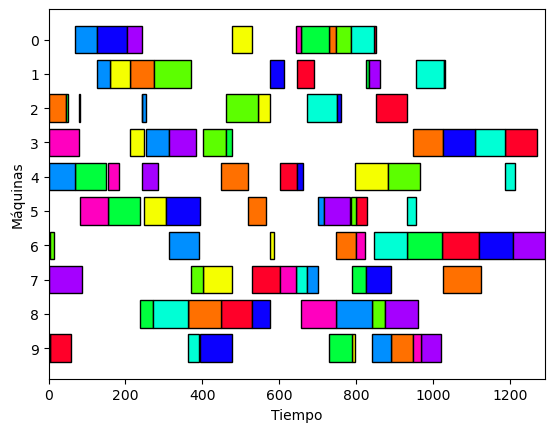

tiempo_total 11.97010350227356


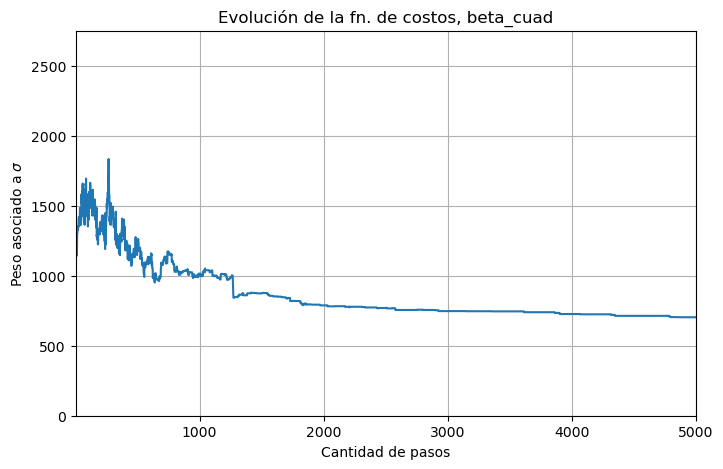

Costo final: 704


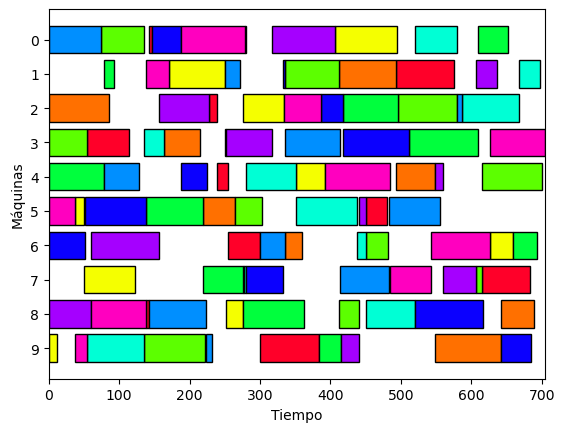

In [11]:
# Parámetros a cambiar
maquinas = 10 # Cantidad de máquinas
tareas = 10 # Cantidad de tareas
n_CM = 5000 # Cantidad de iteraciones
fn_beta = beta_cuad # Elegir: fn_beta, beta_raiz, beta_cuad, beta_pol o beta_exp

# Generamos instancias
lista_instancias_inicial, tmax_inicial, orden_inicial, tiempos_inicial = generar_instancias(maquinas,tareas)

# Ploteamos
print("Costo inicial:", tmax_inicial)
plot_gantt_chart(lista_instancias_inicial, maquinas)

# Corremos simulated annealing
tiempo_inicio = time.time()
pos_final1, pos_finaltiempos, MC1, Pesos1, MC_tiempos1 = sim_ann(n_CM,fn_beta,orden_inicial, tiempos_inicial, tareas, maquinas)
tiempo_final = time.time()
tiempo_total = tiempo_final - tiempo_inicio
print("tiempo_total",tiempo_total)

# Gráfico evolución de costos
x = list(range(1, len(MC1)+1, 1))
plt.figure(figsize=(8,5))
plt.plot(x,Pesos1)
plt.grid()
plt.xlim([1, n_CM])
plt.ylim([0, 1.5*max(Pesos1)])
plt.xlabel('Cantidad de pasos')
plt.ylabel('Peso asociado a $\sigma$')
plt.title('Evolución de la fn. de costos, '+str(fn_beta.__name__))
plt.show()

# Estado final
lista_instancias_final = lista_instancias(MC1[-1],MC_tiempos1[-1],maquinas,tareas)
print("Costo final:",int(Pesos1[-1]))
plot_gantt_chart(lista_instancias_final,maquinas)

A continuación, se implementará un nuevo método llamado $\textit{Genetic Algorithm}$ (GA) o Algoritmo Genético para abordar JSP. Este algoritmo está basado en la teoría de Darwin llamada la supervivencia del más fuerte.

Se genera una población inicial aleatoria de 10 individuos (en este caso, horarios), dando lugar a la primera generación. Esta generación pasará por procesos como la reproducción, cruce y mutación para crear una nueva y mejor población para la siguiente generación.

In [12]:
# Obtener todos los vecinos de un horario
# Nos basamos en la vecindad neighborhood ya definida
def adjacent_swapping(orden,tiempo,filas,columnas):
    # Todos los órdenes intercambiando una operación
    # Repetir lo mismo con los tiempos
    vecindades = []
    tiempos = []
    i_actual = 0
    for operacion in orden:
        for j in range(i_actual,len(orden)):
            x = orden.copy()
            y = tiempo.copy()
            if j != i_actual:
                orden_a,orden_b = x[j],y[j]
                x[j],y[j] = x[i_actual],y[i_actual]
                x[i_actual],y[i_actual] = orden_a,orden_b
                vecindades+= [x]
                tiempos += [y]
        i_actual += 1    
    return vecindades,tiempos,filas,columnas

In [13]:
# Ahora, se crea DG distance, función que representa el número de
# operaciones diferentes entre dos horarios sigma_1 y sigma_2.
def DG_distance(s1,s2,filas,columnas):
    assert len(s1) == len(s2)
    largo = len(s1)
    distancia = 0
    for i in range(largo):
        if s1[i] != s2[i]:
            distancia += 1
    return distancia

$\textit{Crossover}$ o Cruce: entre los padres seleccionados, tiene como objetivo generar un nuevo horario ($\textit{child}$ o hijo), el cual tenga mejor peso que sus padres, para que sea un miembro de la nueva generación, reemplazando al peor horario (en términos de costos).

In [14]:
def sortFirst(val):
    return val[0] 

# Definir cruce entre dos individuos/horarios
def crossover(p1,p2,t1,t2,filas,columnas):
    # Creamos x, será el hijo que se irá guardando en el proceso
    x = q = p1
    tx = tq = t1
    # Calculamos los costos
    costo_x = costos(x,tx,filas,columnas)
    costo_q = costos(q,tq,filas,columnas)
    # Vemos todos los vecinos de x para comparar con el segundo padre
    vecindades_x,tiempos_x,f,c = adjacent_swapping(x,tx,filas,columnas)
    DG = []
    for vecino in vecindades_x:
        DG += [DG_distance(vecino,p2,filas,columnas)]
    i = 0
    for dg in DG:
        dg = [dg,i]
        DG[i] = dg
        i+=1
    # Ordenamos la distancia DG crecientemente
    DG.sort(key=sortFirst)
    vecindades_x_sort = []
    tiempos_x_sort = []
    for dg in DG:
        it = dg[1]
        vecindades_x_sort += [vecindades_x[it]]
        tiempos_x_sort += [tiempos_x[it]]
    # Ahora se comparan los vecinos con p2, el otro padre
    contador=0
    for y in vecindades_x_sort:
        # Calcular el costo de vecino
        tiempo_y = tiempos_x_sort[contador]
        costo_y = costos(y,tiempo_y,filas,columnas)
        if costo_y <= costo_x:
            x = y
            tx = tiempos_x_sort[contador]
            costo_x = costo_y
            if costo_x <= costo_q:
                q = x
                tq = tx
        else:
            u = np.random.random()
            if u <= 0.5:
                x = y
                tx = tiempos_x_sort[contador]
                costo_x = costo_y
                if costo_x <= costo_q:
                    q = x
                    tq = tx
        contador += 1

    return q,tq,filas,columnas

$\textit{Mutation}$ o mutación: se escoge un padre de los dos, y se escoge un vecino que tenga menor costo que el padre, para que sea un miembro de la nueva generación, reemplazando al peor horario (en términos de costos).

In [15]:
# Definir mutación de un individuo/horario
def mutation(p1,t1,filas,columnas):
    # Creamos x, será el hijo que se irá guardando en el proceso
    x = q = p1
    tx = tq = t1
    # Calculamos los costos
    costo_x = costos(x,tx,filas,columnas)
    costo_q = costos(x,tx,filas,columnas)
    # Vemos todos los vecinos de x para comparar con el segundo padre
    vecindades_x,tiempos_x,f,c = adjacent_swapping(x,tx,filas,columnas)
    DG = []
    for vecino in vecindades_x:
        DG+= [DG_distance(vecino,p1,filas,columnas)]
    i = 0
    for dg in DG:
        dg = [dg,i]
        DG[i] = dg
        i+=1
    DG.sort(key=sortFirst,reverse=True)
    vecindades_x_sort = []
    tiempos_x_sort = []
    for dg in DG:
        it = dg[1]
        vecindades_x_sort += [vecindades_x[it]]
        tiempos_x_sort += [tiempos_x[it]]
    contador=0
    # Ahora se comparan los vecinos con p1, el mismo padre
    for y in vecindades_x_sort:
        # Calcular el costo de vecino
        costo_y = costos(y,tiempos_x_sort[contador],filas,columnas)
        if costo_y <= costo_x:
            x = y
            tx = tiempos_x_sort[contador]
            costo_x = costo_y
            if costo_x <= costo_q:
                q = x
                tq = tx
        else:
            u = np.random.random()
            if u <= 0.5:
                x = y
                tx = tiempos_x_sort[contador]
                costo_x = costo_y
                if costo_x <= costo_q:
                    q = x
                    tq = tx
        contador += 1

    return q,tq,filas,columnas

$\textit{Genetic Algorithm}$: luego de 100 generaciones seleccionadas con $\textit{Crossover}$ y $\textit{Mutation}$ (mediante $\textit{Adjacent Swapping}$), se escoge al mejor horario de la generación. Implementemos el código para este algoritmo.

In [16]:
# Se crea el algoritmo genético,
# N es la cantidad de generaciones
# valor es un parámetro predeterminado para ver si se va
# a elegir crossover o mutation
def genetic_algorithm(N,valor,filas,columnas):
    # Para guardar los costos de los hijos
    MC_pesos = [0] * (N+1)
    # Guardar la generación de individuos
    instancias = []
    Tmax = []
    lista_ordenes = []
    lista_tiempos = []
    for i in range(10):
        instancias_i,tmax_i,orden_i,tiempos_i=generar_instancias(columnas,filas) #cambio
        instancias += [instancias_i]
        Tmax += [tmax_i]
        lista_ordenes += [orden_i]
        lista_tiempos += [tiempos_i]
    copia_instancias = instancias.copy()
    copia_Tmax = Tmax.copy()
    MC_pesos[0] = Tmax[0]
    
    # Iteramos la cantidad de N veces, es decir, se crean N generaciones.
    for j in range(1,N+1):
        # Tomar valores aleatorios y llamarlos p1 y p2,
        # extraer índices aleatorios
        indice_p1 = random.randint(0,9)
        indice_p2 = random.randint(0,9)
        while indice_p1 == indice_p2:
            indice_p2 = random.randint(0, 9)
        p1 = lista_ordenes[indice_p1]
        p2 = lista_ordenes[indice_p2]
        p1_tiempo = lista_tiempos[indice_p1]
        p2_tiempo = lista_tiempos[indice_p2]
        p1_instancia = instancias[indice_p1]
        p2_instancia = instancias[indice_p2]
        p1_tmax = Tmax[indice_p1]
        p2_tmax = Tmax[indice_p2]
        
        # Calcular DG entre p1 y p2
        DG = DG_distance(p1,p2,filas,columnas)
        
        # Comparamos esta distancia con el predefinido
        if DG <= valor:
            # Se crea el hijo a partir de mutación
            child,child_tiempo,z,zz = mutation(p1,p1_tiempo,filas,columnas)
            vecindades_child,tiempos_vecindades_child,zzz,zzzz = adjacent_swapping(child,child_tiempo,filas,columnas)
            costos_child = [0] * len(vecindades_child)
            # Se ven los costos
            for k in range(len(costos_child)):
                costos_child[k] = costos(vecindades_child[k],tiempos_vecindades_child[k],columnas,filas)
            M_c = min(costos_child)
            triangulo_child = costos_child.index(M_c)
            
            child_prima_vec = vecindades_child[triangulo_child]
            child_prima_tiempo = tiempos_vecindades_child[triangulo_child]
            child_prima_costo = costos(child_prima_vec,child_prima_tiempo,filas,columnas)
            child_prima_instancia = lista_instancias(child_prima_vec,child_prima_tiempo,columnas,filas)
            
            # Extraemos el peor tiempo de la generación
            t_peor = max(Tmax)
            t_peor_indice = Tmax.index(t_peor)
            
            # Comparamos el costo del hijo por el peor de la generación actual
            if child_prima_costo < t_peor:
                instancias[t_peor_indice] = child_prima_instancia
                Tmax[t_peor_indice] = child_prima_costo
                lista_ordenes[t_peor_indice] = child_prima_vec
                lista_tiempos[t_peor_indice] = child_prima_tiempo
            # Guardamos el costo del j-ésimo hijo para ver la evolución
            MC_pesos[j] = child_prima_costo
        
        # elif DG > valor:
        else:
            # Se crea el hijo a partir de crossover
            child,child_tiempo,z,zz = crossover(p1,p2,p1_tiempo,p2_tiempo,filas,columnas)
            vecindades_child,tiempos_vecindades_child,zzz,zzzz = adjacent_swapping(child,child_tiempo,filas,columnas)
            costos_child = [0] * len(vecindades_child)
            for k in range(len(costos_child)):
                costos_child[k] = costos(vecindades_child[k],tiempos_vecindades_child[k],columnas,filas)
            M_c = min(costos_child)
            triangulo_child = costos_child.index(M_c)
            
            child_prima_vec = vecindades_child[triangulo_child]
            child_prima_tiempo = tiempos_vecindades_child[triangulo_child]
            child_prima_costo = costos(child_prima_vec,child_prima_tiempo,filas,columnas)
            child_prima_instancia = lista_instancias(child_prima_vec,child_prima_tiempo,columnas,filas)
            
            # Extraemos el peor tiempo de la generación
            t_peor = max(Tmax)
            t_peor_indice = Tmax.index(t_peor)
            
            # Comparamos el costo del hijo por el peor de la generación actual
            if child_prima_costo < t_peor:
                instancias[t_peor_indice] = child_prima_instancia
                Tmax[t_peor_indice] = child_prima_costo
                lista_ordenes[t_peor_indice] = child_prima_vec
                lista_tiempos[t_peor_indice] = child_prima_tiempo
            # Guardamos el costo del j-ésimo hijo para ver la evolución
            MC_pesos[j] = child_prima_costo
    return instancias, Tmax, lista_ordenes, lista_tiempos, MC_pesos, copia_instancias, copia_Tmax

Ahora, el propósito es probar $\textit{Genetic Algorithm}$ para distintas cantidades de máquinas y tareas.

tiempo_total 3.7560946941375732
Costo inicial: 821


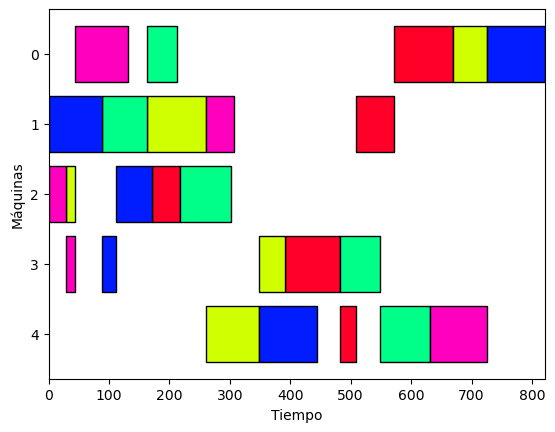

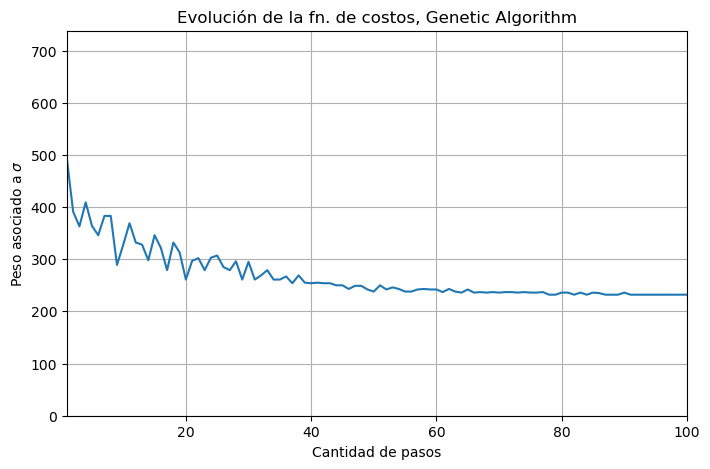

Costo final: 232


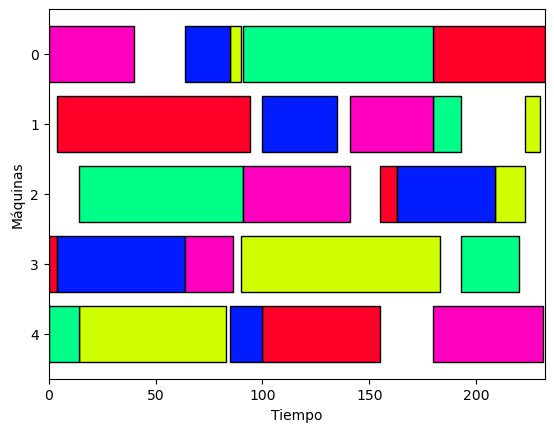

In [17]:
# Ploteamos GA
# Parámetros a cambiar.
tareas = 5 # Cantidad de tareas
maquinas = 5 # Cantidad de máquinas
n_CM = 100 # Cantidad de iteraciones
valor = 4 # Parámetro asociado al algoritmo.

# Ploteamos
tiempo_inicio = time.time()
instancias, Tmax, lista_ordenes, lista_tiempos, MC_pesos,copia_instancias, copia_Tmax = genetic_algorithm(n_CM,valor,tareas,maquinas)
tiempo_final = time.time()
tiempo_total = tiempo_final - tiempo_inicio
print("tiempo_total",tiempo_total)

maximo = max(copia_Tmax)
ind_max = copia_Tmax.index(maximo)
minimo = min(Tmax)
ind_min = Tmax.index(minimo)

instancia_max = copia_instancias[ind_max]
instancia_min = instancias[ind_min]

print("Costo inicial:",maximo)
plot_gantt_chart(instancia_max,maquinas)

x = list(range(1, len(MC_pesos)+1, 1))
# Gráfico evolución de costos
plt.figure(figsize=(8,5))
plt.plot(x,MC_pesos)
plt.grid()
plt.xlim([1, n_CM])
plt.ylim([0, 1.5*max(MC_pesos)])
plt.xlabel('Cantidad de pasos')
plt.ylabel('Peso asociado a $\sigma$')
plt.title('Evolución de la fn. de costos, Genetic Algorithm')
plt.show()

print("Costo final:",minimo)
plot_gantt_chart(instancia_min,maquinas)

A continuación, dejamos las referencias utilizadas. Nos inspiramos principalmente en dos papers, uno de ellos analiza simulated annealing y el otro algoritmo genético.

$\textbf{Referencias}$

[1] Kolonko, M. (1999) Some New Results on
Simulated Annealing Applied to the Job
Shop Scheduling Problem. European Journal of Operational Research, 113, 123-136.

[2] Omar, M., Baharum, A., Hasan, Y. (2006)
A Job-Shop Scheduling problem (JSSP)
using Genetic Algorithm (GA). 2nd IMTGT Regional Conference on Mathematics,
Statistics and Applications.